# Naive implementation of statevector simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# Gate Definitions
X = np.array([[0, 1], [1, 0]])
H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
I = np.eye(2)
CNOT = np.array([[1, 0, 0, 0],
                 [0, 1, 0, 0],
                 [0, 0, 0, 1],
                 [0, 0, 1, 0]])

In [3]:
import pennylane as qml
import pennylane.numpy as np

#### Quantum Circuit simulation using Pennylane

In [4]:
def apply_quantum(qubits):
    dev = qml.device("lightning.qubit", wires=qubits)

    @qml.qnode(dev)
    def circuit(qubits):
        for wire in range(qubits):
            qml.QubitUnitary(X, wires=wire)
            qml.QubitUnitary(H, wires=wire)
        for wire in range(qubits-1):
            qml.QubitUnitary(CNOT, wires=[wire,wire+1])
        return qml.state()
    
    state = circuit(qubits)
    return state

In [5]:
# Run Circuit with Matrix Multiplication
state1 = apply_quantum(4)
state1

array([ 0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j,
        0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j,
        0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j])

In [6]:
# Runtime Plot
qubits = range(1, 25)
times = []
states = []
for n in qubits:
    start = time.time()
    states.append(apply_quantum(n))
    times.append(time.time() - start)

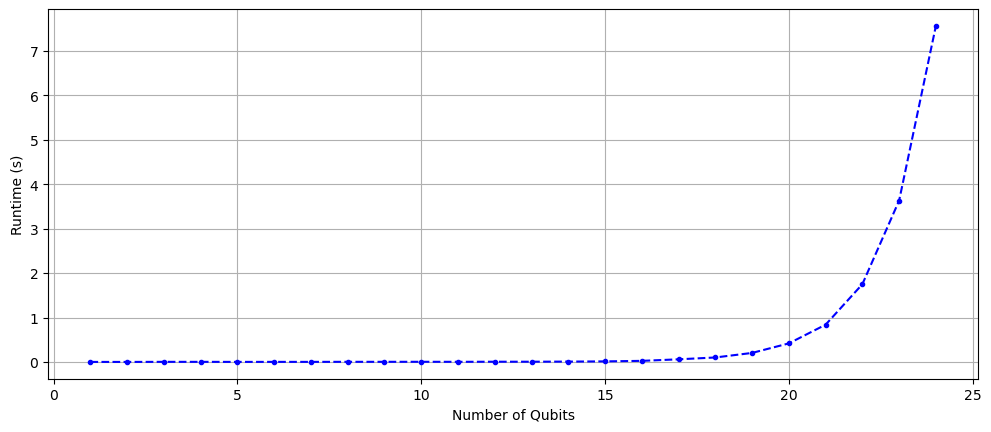

In [7]:
plt.figure().set_figwidth(12)
plt.grid()
plt.plot(qubits, times,marker = ".",ls = "--",c="b")
plt.xlabel('Number of Qubits')
plt.ylabel('Runtime (s)')
plt.show()

# Task 1 : Subtask 1

### Using only matrix multiplication

Direct sum function which would give the matrix direct sum $c = a \oplus b$ for operator calculation for multi qubit states.

In [8]:
def direct_sum(a, b):
    m1, n1 = np.shape(a)
    m2, n2 = np.shape(b)
    c = np.zeros((m1 + m2, n1 + n2))
    
    c[:m1, :n1] = a   
    c[m1:, n1:] = b
    return c

In [9]:
direct_sum([[1,0],[0,1]],[[9,9],[9,9]])

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 9., 9.],
        [0., 0., 9., 9.]], requires_grad=True)

In [10]:
# so we already have our operators, now we will calculate time required for computation.
def init_state(qubits):
    state = [1+0j,0]
    for _ in range(qubits-1):
        state = np.kron(state,[1,0])
    return state

In [11]:
print(len(init_state(4)))
init_state(4)

16


tensor([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j], requires_grad=True)

In [12]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer, AerSimulator
from qiskit.quantum_info import Operator

# function to calculate the cnot cascaded cnot operator for multiple qubits
def cnot_op(qubits):
    c = QuantumCircuit(qubits)
    for i in range(qubits-1):
        c.cx(i+1,i)
    #print(c)
    matrix = Operator.from_circuit(c)
    return matrix.data

In [13]:
print("sample: cnot operator for 2 qubits")
cnot_op(2)

sample: cnot operator for 2 qubits


array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]])

In [14]:
cnot_op(4).shape[0]

16

In [15]:
def apply_numpy(qubits):
    initial_state = init_state(qubits)
    xop= 1
    hop= 1
    cnotop = cnot_op(qubits)
    state_vec = initial_state
    for _ in range(qubits):
        xop = np.kron(xop,X)
        hop = np.kron(hop,H)
    
    state_vec = np.dot(np.dot(hop,xop),state_vec)
    state_vec = np.dot(cnotop,state_vec)
    return state_vec

In [16]:
# Run Circuit with Matrix Multiplication
state2 = apply_numpy(4)
state2

tensor([ 0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j,
        -0.25+0.j,  0.25+0.j,  0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j,
        -0.25+0.j,  0.25+0.j, -0.25+0.j,  0.25+0.j], requires_grad=True)

In [17]:
# Runtime Plot
qubits = range(1, 12)
times = []
states = []
for n in qubits:
    start = time.time()
    states.append(apply_numpy(n))
    times.append(time.time() - start)

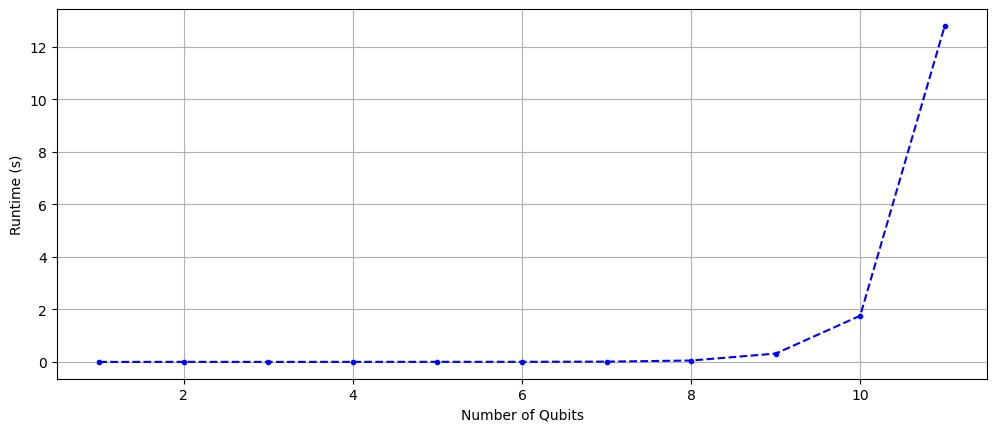

In [18]:
plt.figure().set_figwidth(12)
plt.grid()
plt.plot(qubits, times,marker = ".",ls = "--",c="b")
plt.xlabel('Number of Qubits')
plt.ylabel('Runtime (s)')
plt.show()

The simulation is run for max 12 qubits because classical matrix algrbra using the naive method beyond that limit becomes increasingly difficult.

## Without using the qiskit functionality for cnot gate

In [19]:
np.shape(CNOT)[0]

4

In [20]:
def apply_numpy_without_qiskit(qubits):
    initial_state = init_state(qubits)
    xop = 1
    hop = 1
    cnotop = 1
    state_vec = initial_state
    
    for _ in range(qubits):
        xop = np.kron(xop,X)
        hop = np.kron(hop,H)
    for _ in range(qubits//2):
        cnotop = np.kron(cnotop,CNOT)
    
    if not qubits%2==0 and qubits > 1:
        dims = np.shape(cnotop)[0]
        cnotop = direct_sum(np.eye(dims),cnotop)
    
    state_vec = np.dot(np.dot(hop,xop),state_vec)
    state_vec = np.dot(cnotop,state_vec)
    #print(cnotop)
    return state_vec

In [21]:
# Run Circuit with Matrix Multiplication
state2 = apply_numpy_without_qiskit(4)
state2

tensor([ 0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j,
        -0.25+0.j,  0.25+0.j,  0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j,
        -0.25+0.j,  0.25+0.j, -0.25+0.j,  0.25+0.j], requires_grad=True)

In [22]:
# Run Circuit with Matrix Multiplication
state3 = apply_numpy_without_qiskit(3)
state3

tensor([ 0.35355339+0.j, -0.35355339+0.j, -0.35355339+0.j,
         0.35355339+0.j, -0.35355339+0.j,  0.35355339+0.j,
        -0.35355339+0.j,  0.35355339+0.j], requires_grad=True)

In [23]:
# Runtime Plot
qubits = range(1, 12)
times_1 = []
states_1 = []
for n in qubits:
    start = time.time()
    states_1.append(apply_numpy(n))
    times_1.append(time.time() - start)

In [24]:
# Runtime Plot
qubits = range(1, 12)
times_2 = []
states_2 = []
for n in qubits:
    start = time.time()
    states_1.append(apply_numpy_without_qiskit(n))
    times_2.append(time.time() - start)

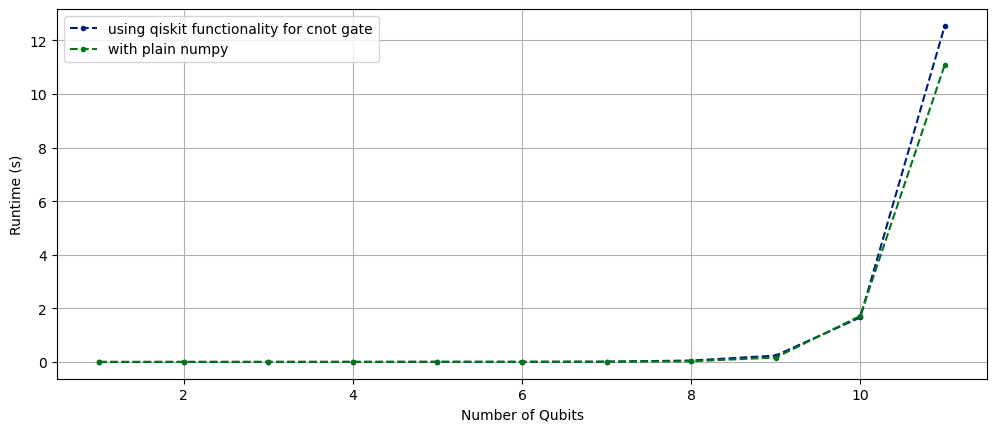

In [25]:
plt.style.use("seaborn-v0_8-dark-palette")
plt.figure().set_figwidth(12)
plt.grid()
plt.plot(qubits, times_1,marker = ".",ls = "--",label = "using qiskit functionality for cnot gate")
plt.plot(qubits, times_2,marker = ".",ls = "--",label = "with plain numpy")
plt.xlabel('Number of Qubits')
plt.ylabel('Runtime (s)')
plt.legend()
plt.show()

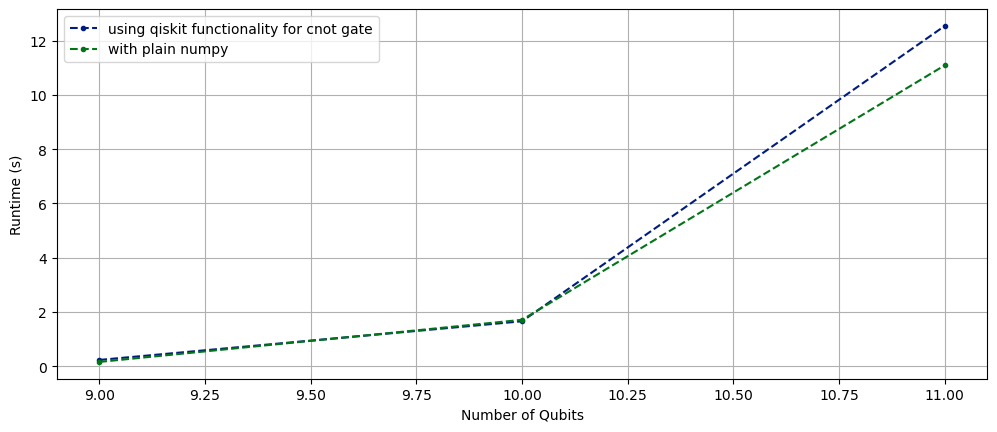

In [26]:
plt.style.use("seaborn-v0_8-dark-palette")
plt.figure().set_figwidth(12)
plt.grid()
plt.plot(qubits[8:], times_1[8:],marker = ".",ls = "--",label = "using qiskit functionality for cnot gate")
plt.plot(qubits[8:], times_2[8:],marker = ".",ls = "--",label = "with plain numpy")
plt.xlabel('Number of Qubits')
plt.ylabel('Runtime (s)')
plt.legend()
plt.show()

As expected the additional usage of qiskit to extract the CNOT gate takes slightly more time, although only for basic linear algebraic calculations still as is shown the time adds up.

# Tensor method

In this case instead of using the numpy method we use the tensor method where ibstead of using a 1D vector we use tensor shapes. Therefore instead of representing $|00\rangle$ as `[1,0,0,0]`we instead represent it as `[[1,0],[1,0]]`.

For the Tensor simulation program we convert every operator into a shape ((2,)* n). 

In [55]:
CNOT = CNOT.reshape([2]*4)+0j 
CNOT, X+0j, H+0j, I+0j

(array([[[[1.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j]],
 
         [[0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j]]],
 
 
        [[[0.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j]],
 
         [[0.+0.j, 0.+0.j],
          [1.+0.j, 0.+0.j]]]]),
 array([[0.+0.j, 1.+0.j],
        [1.+0.j, 0.+0.j]]),
 array([[ 0.70710678+0.j,  0.70710678+0.j],
        [ 0.70710678+0.j, -0.70710678+0.j]]),
 array([[1.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j]]))

In [56]:
q = TensorCircuitSimulator(3)
q.state

tensor([[[1., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]], requires_grad=True)

In [57]:
q.apply_single_qubit_gate(X,1)
q.state

tensor([[[0., 0.],
         [1., 0.]],

        [[0., 0.],
         [0., 0.]]], requires_grad=True)

In [58]:
control =1
target = 2
axes = list(range(q.n_qubits))
axes.remove(control)
axes.remove(target)
axes = [control, target] + axes
state = np.transpose(q.state, axes)
state, axes, state.shape

(tensor([[[0., 0.],
          [0., 0.]],
 
         [[1., 0.],
          [0., 0.]]], requires_grad=True),
 [1, 2, 0],
 (2, 2, 2))

In [59]:
# Now operation is local, then restore order
shape = state.shape
state = state.reshape(2, 2, -1)  # Group other qubits
state

tensor([[[0., 0.],
         [0., 0.]],

        [[1., 0.],
         [0., 0.]]], requires_grad=True)

In [61]:
state = np.tensordot(state, CNOT, axes=([0,1], [2,3]))
state

tensor([[[0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j]],

        [[0.+0.j, 1.+0.j],
         [0.+0.j, 0.+0.j]]], requires_grad=True)

In [62]:
class TensorCircuitSimulator:
    def __init__(self, n_qubits):
        self.n_qubits = n_qubits
        self.state = np.zeros((2,) * n_qubits)
        self.state[(0,) * n_qubits] = 1.0
        
    def apply_single_qubit_gate(self, gate, target):
        # After tensordot, new axis is at end
        self.state = np.tensordot(self.state, gate, axes=(target, 1))

        # Move new axis from end to target position
        axes = list(range(self.n_qubits))
        axes.insert(target, self.n_qubits-1)
        axes.pop()
        self.state = np.transpose(self.state, axes)

    def apply_cnot(self, control, target):
        if len(self.state.shape) > 1:
            # Rearrange to get control/target adjacent
            axes = list(range(self.n_qubits))
            axes.remove(control)
            axes.remove(target)
            axes = [control, target] + axes
            state = np.transpose(self.state, axes)

            # Now operation is local, then restore order
            shape = state.shape
            state = state.reshape(2, 2, -1)  # Group other qubits
            state = np.tensordot(state, CNOT, axes=([0,1], [2,3]))

In [63]:
def benchmark_tensor_simulation(max_qubits):
    times = []
    qubits = list(range(2, max_qubits + 1))
    
    for n in qubits:
        start = time.time()
        
        # Create and run a test circuit
        sim = TensorCircuitSimulator(n)
        for i in range(n-1):
            sim.apply_single_qubit_gate(X, i)
            sim.apply_single_qubit_gate(H, 0)
        
        sim.apply_cnot(0, 1)
        times.append(time.time() - start)
    
    plt.style.use("seaborn-v0_8-dark-palette")
    plt.figure().set_figwidth(12)
    plt.plot(qubits, times, marker = ".", ls = "--")
    plt.xlabel('Number of qubits')
    plt.ylabel('Runtime (seconds)')
    # plt.yscale('log')
    plt.grid()
    plt.title('Tensor-based Quantum Circuit Simulation Runtime')
    plt.show()
    
    return qubits, times

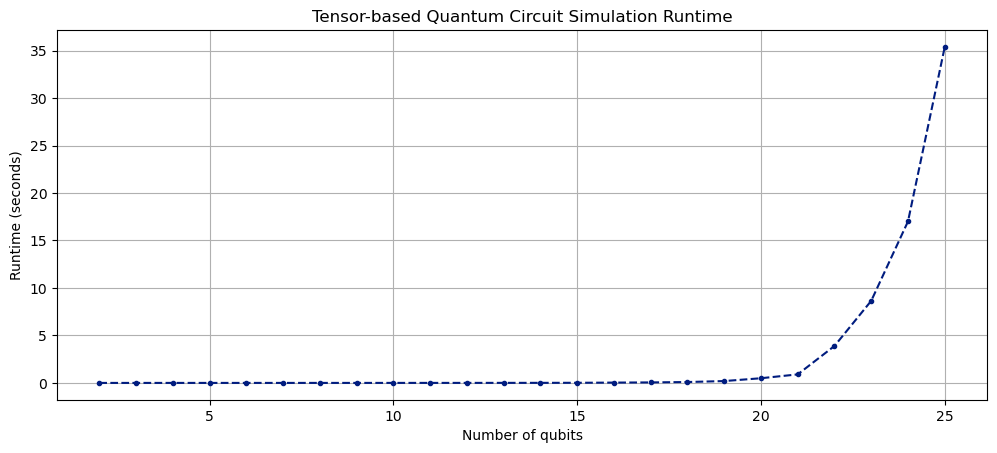

In [64]:
qubits, times = benchmark_tensor_simulation(25)

Major improvement as it runs for >25 qubits which would have been very difficult using traditional numpy implementation

## BONUS